# Halloween Challenge

Solution and Notebook made by Mattia Sabato (https://github.com/Mattizza) and Claudio Savelli (https://github.com/ClaudioSavelli)!

Challenge proposed during the 2023/2024 edition of the course. We are in the realm of *SET COVERING*, an NP-hard problem for which we are requested to find the **best solution** with the **fewest calls** to the fitness functions for:

* `num_points = [100, 1_000, 5_000]`
* `num_sets = num_points`
* `density = [.3, .7]` 

The problem has been settled so to have the **same pool of candidate sets** for each participant; in this way, it is possible to easily make a comparison between different solutions! We are glad to introduce an original algorithm which we designed in order to achieve several goals:

* Get a solution **close to the best** possible;
* Keep the number of calls to the fitness function **low**;
* Avoid a huge amount of computations and design a **very fast** algorithm;
* °Put ourselves in a **realistic scenario** where we don't necessarily have the amount of knowledge we were given in this case.

---
°By shifting many of the computations inside the fitness function, one would be able to **greatly reduce** the number of calls. This happens because we are simply moving all the computational burden inside the function, which instead should only evaluate the current and the candidate state. In order to keep our solution as **fair** and **realistic** as possible (and, so, to not exploit tricks to solve the problem in 3 steps, quite unrealistic isn't it?) we decided to use the most simple evaluation function, i.e. the one proposed by the Professor. Moreover, we also kept the most basic tweak function and we strongly avoided the need for **extensive calculations** during the search for the solution. We believe that, given the particular structure of the problem, finding a perfect solution would be easy; we don't like easy or pre-made things, so we designed from scratch a new algorithm to find the best trade-off between number of calls and goodness of the solution. Finally, even though stochastic, our algorithm, if tuned adequately, has a quite low variance; this is very important since, thanks to the high speed at which it runs, several iterations can be done until the best possible solution is found. Hope you enjoy! :)

## Set Up

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from itertools import product
from random import random, randint, seed, sample, choice
from scipy import sparse
from copy import copy
from functools import reduce
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

%matplotlib inline


# Function provided by the Professor to define the problem.
def make_set_covering_problem(num_points, num_sets, density):
    """Returns a sparse array where rows are sets and columns are the covered items"""
    seed(num_points * 2654435761 + num_sets + density)
    sets = sparse.lil_array((num_sets, num_points), dtype = bool)
    for s, p in product(range(num_sets), range(num_points)):
        if random() < density:
            sets[s, p] = True
    for p in range(num_points):
        sets[randint(0, num_sets - 1), p] = True
    return sets


# Set the number of elements/sets.
n = 100
PROBLEM_SIZE = NUM_SETS = n

# Define the sets.
x = make_set_covering_problem(n, n, .3)

# Just to ease the process.
SETS = x.toarray()
print("Element at row=42 and column=42:", x[1, 1])

Element at row=42 and column=42: False


## Methodology

To test the effectiveness of our solution, we need to define a *baseline* and a *benchmark*. The first is our **lower bound**, i.e. the performance we would get when considering a simple Random Tweaking; the idea is to **not perform worse** than this! The second is our **upper bound**, and it is what we would like to **approach as much as possible** with our solution; in order to have a very nice approximation of the optimum, we compute the solution using a Steepest Ascent algorithm.

In all the tests we use the following counters:

* `count_fitness`: the number of times `fitness` is called;
* `count_updates`: the number of updates of the current solution;
* `missing_steps`: the number of steps with no improvements before stopping the algorithm.

We always initialize `count_fitness = 1`, so to keep into account the first evaluation of the algorithm, and then we increase it by 1 for each comparison. However, in the following notebook you will usually find `fitness(new_state) > fitness(current_state)`, so should we not increase it by 2? Actually, since **in this specific case** the evaluation of `fitness` is **not computationally expensive**, we lazily avoid to store each time its result in a dedicated variable and simply recompute it each time. Even though wrong (at a code level) in a general case, it actually causes no problems in this specific situation (at a latency level), so we decided to keep it here and increment the counter just by 1 (at a conceptual level).

For what does it concerns `count_updates`, it represents the number of times we find a solution better than the actual one. It actually does not cover a paramount importance, but it is always nice to keep track of these additional statistics.

Finally, when `missing_steps` reaches a pre-defined treshold, the algorithm stops and returns the actual solution. This is done so to avoid running (and evaluating) for a number of times always equal to the number of steps.

### Baseline

`Random Tweak Search` is considered as our **baseline**, a lower bound representing the minimum we need to achieve with our method. We have defined it by taking (if not present) or removing (if already present) randomly, at each step, just one `set` before calling `fitness`.

In [105]:
def tweak(state):
    new_state = copy(state)                 # The most simple tweaking: it  
    index = randint(0, PROBLEM_SIZE - 1)    # just changes the boolean value
    new_state[index] = not new_state[index] # associated to a random index.
    return new_state

def fitness(state):
    cost = sum(state)               # Prioritizes the number of elements        
    valid = np.sum(reduce(          # covered and subsequently the number
        np.logical_or,              # of sets needed to do so.
        [SETS[i] for i, t in enumerate(state) if t],                                          
        np.array([False for _ in range(PROBLEM_SIZE)]),
                          )
                   )
    return valid, -cost


In [106]:
current_state = [False for _ in range(PROBLEM_SIZE)]
print('(#elements_covered, #sets)\n')
print(fitness(current_state))

count_fitness = 1
count_updates = 0
missing_steps = 0

for step in range(100_000):
    
    new_state = tweak(current_state)
    count_fitness += 1
    
    if fitness(new_state) > fitness(current_state):
        current_state = new_state
        count_updates += 1
        print(fitness(current_state))
        missing_steps = 0  
    
    else:
        missing_steps += 1
    
    if missing_steps == 1000:   # Arbitrary.
        break
        
print('\nCount Fitness:', count_fitness)
print('Count Updates:', count_updates)

(#elements_covered, #sets)

(0, 0)
(31, -1)
(51, -2)
(62, -3)
(78, -4)
(88, -5)
(92, -6)
(95, -7)
(96, -8)
(97, -9)
(99, -10)
(100, -11)
(100, -10)
(100, -9)
(100, -8)

Count Fitness: 1185
Count Updates: 14


### Steepest Ascent

As our **benchmark**, we have considered the `Steepest Ascent Search`, an upper bound to measure the goodness of the solutions obtained either with the baseline or with our method. At each step, every set to take (if not present) or remove (if present) is evaluated, and only the best one is retained. This method does not guarantee an absolute maximum, as the steepest ascent may still incur into local maxima. Still, we consider this solution acceptable, and we label it as the ideal goal to achieve. Finally, notice how, in this specific case, the number of calls to `fitness` is very high, since it will always be equal to the number of steps fixed times `PROBLEM_SIZE`.

In [107]:
def tweak(state, index):
    new_state = copy(state)                 # In this case we  
    index = randint(0, PROBLEM_SIZE - 1)    # keep track also
    new_state[index] = not new_state[index] # of the index.
    return new_state

def fitness(state):
    cost = sum(state)                       
    valid = np.sum(reduce(          
        np.logical_or,              
        [SETS[i] for i, t in enumerate(state) if t],                                          
        np.array([False for _ in range(PROBLEM_SIZE)]),
                          )
                   )
    return valid, -cost


In [108]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
print('(#updates, step, #calls_to_fitness, fitness)\n')
print(fitness(current_state))

count_fitness = 0
best_index = 0
count_updates = 0

for step in range(1000):
    
    for i in range(PROBLEM_SIZE):
        new_state = tweak(current_state, i)
        
        count_fitness += 1
        if fitness(new_state) > fitness(candidate_state):
            candidate_state = new_state
            best_index = i
            count_updates += 1
            print(count_updates, step, count_fitness, fitness(candidate_state))

    current_state = candidate_state   

print('\nCount Fitness:', count_fitness)
print('Count Updates:', count_updates)

(#updates, step, #calls_to_fitness, fitness)

(0, 0)
1 0 1 (32, -1)
2 0 2 (37, -1)
3 0 16 (40, -1)
4 1 101 (56, -2)
5 1 102 (59, -2)
6 1 103 (65, -2)
7 1 148 (66, -2)
8 1 154 (67, -2)
9 2 201 (75, -3)
10 2 202 (76, -3)
11 2 204 (78, -3)
12 2 212 (79, -3)
13 2 219 (81, -3)
14 2 239 (82, -3)
15 2 255 (84, -3)
16 3 301 (85, -4)
17 3 302 (88, -4)
18 3 303 (90, -4)
19 3 308 (92, -4)
20 3 355 (94, -4)
21 4 401 (95, -5)
22 4 403 (96, -5)
23 4 406 (97, -5)
24 4 411 (98, -5)
25 5 501 (99, -6)
26 5 510 (100, -6)

Count Fitness: 100000
Count Updates: 26


### Our Method

Finally, we have tested our algorithm, which can be partitioned in few steps:

1) **Precompute the pairwise distance/similarity** between the elements in `SETS`. Since we have arrays of `bool`, we can see them in a mathematical fashion as vectors of 1's and 0's, representing points/vectors in the space. During our experiments, we have tuned three different metrics: the **euclidean distance**, the **cosine similarity** and the **manhattan distance**;
2) **Cluster the sets** based on the precomputed measure. In our experiments we have considered a simple hierarchical clustering, but you can use you favourite clustering technique and test how does it perform! Given the nature of the algorithm we have chosen, we also had to tune where to cut the dendogram;
3) Once we have the clusters, we proceed as follows: at each step we **sample** one set from each cluster with equal probability, we **evaluate** `fitness` for each of them, and we select the **best one** (in a steepest ascent like way). How this can help us? First of all, instead of evaluating, say, 1000 points, if we have 20 clusters we need to evaluate only 20 points (50x cheaper). Finally, we claim that the amount of information we lose in this way is not that relevant since all the sets in a given cluster are supposed to be similar.

This is the first version of our algorithm, and it already works pretty well! However, we have decided to add a little extra to further reduce the number of computations keeping the same quality of the solution.

4) At each step, instead of sampling from all the clusters, we decide to **prune** some of them. In 2., once we have defined the clusters, we compute a **manifest** for each of them in which we store, for every element, the probability to cover it, if sampling from that cluster. Then, at every step, we compute the manhattan (tunable) distance between our current solution and each of the manifest; the higher this distance, the more different is the cluster from our current solution and the higher the probability to sample a useful set! Finally, we keep only the *top-n* less similar cluster and we sample only from them. This is done at every step, so the list of pruned cluster is updated at every step depending on the current solution.

The second version of our algorithm works **even better than the first**! It is able to find a very good solution in a small number of steps, and it outperforms all the results obtained with the first version. It is stochastic, so the solution it is not always the same, but we actually really like this aspect! The aspects that we like the most are its speed and its low variance, once fixed the hyperparameters.

In the following you will find the implementation of the second version and a little workflow to test it if you wish!

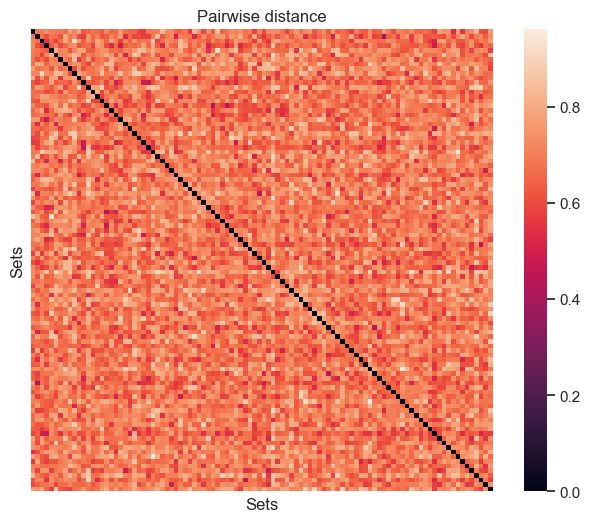

In [109]:
# Run this cell if you want to visualize the pairwise distances, but not needed
# for the following.
similarity_matrix = cosine_similarity(SETS * 1)

sns.set()  
plt.figure(figsize = (8, 6))

sns.heatmap(1 - similarity_matrix, annot = False, 
            square = True, cbar = True, xticklabels = False, yticklabels = False)

plt.xlabel("Sets")
plt.ylabel("Sets")
plt.title("Pairwise distance")
plt.show()

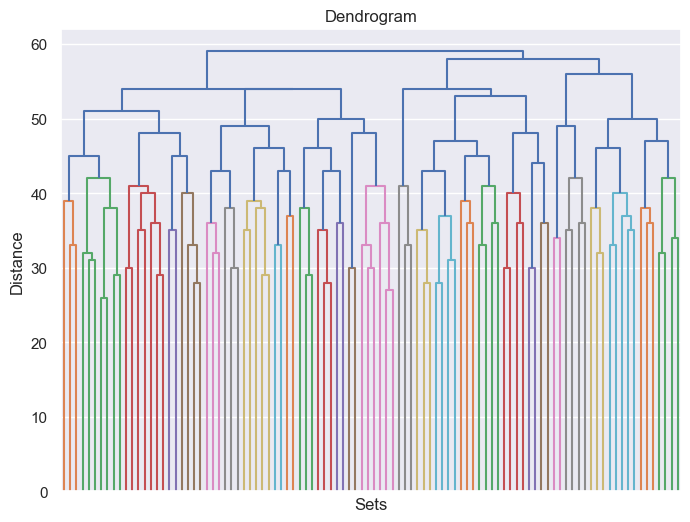

In [110]:
# Perform hierarchical clustering and plot the dendogram.
linkage_matrix = linkage(SETS, method = 'complete', metric = 'cityblock')

threshold = 43

plt.figure(figsize = (8, 6))
dendrogram(linkage_matrix, no_labels = True, color_threshold = threshold)
plt.title('Dendrogram')
plt.xlabel('Sets')
plt.ylabel('Distance')
plt.show()

clusters = fcluster(linkage_matrix, threshold, criterion = 'distance')

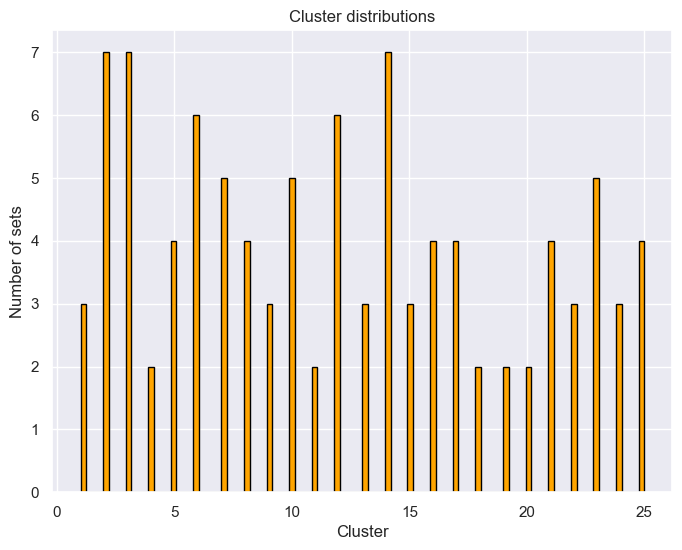

In [111]:
# Plot the numerosity of and in the clusters.
plt.figure(figsize = (8, 6))
plt.hist(clusters, bins = len(clusters), color = 'orange', edgecolor = 'black')
plt.title('Cluster distributions')
plt.xlabel('Cluster')
plt.ylabel('Number of sets')
plt.show()

In [112]:
# Compute the manifests for each cluster.
dict_cluster_set = {clusters[i]:[] for i in range(PROBLEM_SIZE)}

for set in range(len(clusters)):
    dict_cluster_set[clusters[set]].append(set)

dict_cluster_weight = {}

for k, v in dict_cluster_set.items():
    val = sum(SETS[v] * 1) /len(v)
    dict_cluster_weight[k] = val


In [113]:
def fitness(state):
    cost = sum(state)
    valid = np.sum(
        reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    )
    return valid, -cost

def tweak(state, index):
    new_state = copy(state)
    new_state[index] = not new_state[index]
    return new_state

def actual_solution(state): 
    vector = reduce(
            np.logical_or,
            [SETS[i] for i, t in enumerate(state) if t],
            np.array([False for _ in range(PROBLEM_SIZE)]),
        )
    return vector * 1

In [114]:
current_state = [False for _ in range(PROBLEM_SIZE)]
candidate_state = current_state
flag = False

print('(#updates, step, #calls_to_fitness, fitness)\n')
print(fitness(current_state))

count_fitness = 0
best_index = 0
count_updates = 0
missing_steps = 0

for step in range(10000):
    
    candidates = []
    selected = []

    clusters_to_select = []
    cs = actual_solution(current_state)
    for cluster in dict_cluster_weight.keys():
     
        clusters_to_select.append((cluster,cdist([cs], [dict_cluster_weight[cluster]], metric = 'cityblock')[0][0]))
 
    clusters_to_select = sorted(clusters_to_select, key = lambda x: x[1], reverse = True)[:int(len(clusters_to_select) * 2/4)]

    for name, value in clusters_to_select:
        chosen_one = choice(dict_cluster_set[name])     
        selected.append(chosen_one)                     
        candidates.append(SETS[chosen_one])            
    
    for i in range(len(candidates)):
        
        new_state = tweak(current_state, selected[i])
        
        count_fitness += 1
        if fitness(new_state) > fitness(candidate_state):
            candidate_state = new_state
            best_index = i
            count_updates += 1
            print(count_updates, step, count_fitness, fitness(candidate_state))
            missing_steps = 0
        else:
            missing_steps += 1
    
        if missing_steps == 50:
            flag = True
            break
        
    if flag:
        break

    current_state = candidate_state   

print('\nCount Fitness:', count_fitness)
print('Count Updates:', count_updates)

(#updates, step, #calls_to_fitness, fitness)

(0, 0)
1 0 1 (42, -1)
2 1 13 (66, -2)
3 2 25 (78, -3)
4 2 26 (80, -3)
5 2 33 (82, -3)
6 3 37 (88, -4)
7 3 39 (91, -4)
8 4 49 (96, -5)
9 5 61 (97, -6)
10 5 63 (100, -6)

Count Fitness: 113
Count Updates: 10


## Experimental Results

### Our Method VS Baseline/Benchmark

Experiments with different distances comparing against the **baseline** and the **benchmark**. Each tuple has the following format: (*#fitness_calls*, *cost*, *#steps*, *#steps_with_no_improvements_to_stop*), along with [*comparison_with_baseline*]. For each configuration, all the elements have been covered.

| Size | P       | BASELINE              | BENCHMARK                      | OURS (w/euclidean)             | OURS (w/cosine)                 | OURS (w/manhattan)             |
|:----:|:-------:|----------------------:|-------------------------------:|-------------------------------:|--------------------------------:|-------------------------------:|
| 100  | 0.3     | (1150, -9, 15, 1000)  | ($\infty$, -6, 5, $\infty$)    | (200, -6, 5, 50) [**x5.8**]    | (180, -6, 6, 50) [**x6.4**]     | (170, -6, 6, 40) [**x6.8**]    |
| 1000 | 0.3     | (2470, -14, 20, 2000) | ($\infty$, -12, 31, $\infty$)  | (443, -13, 12, 50) [**x5.6**]  | (380, -12, 12, 50) [**x6.5**]   | (246, -11, 11, 50) [**x10.0**] |
| 5000 | 0.3     | (6500, -18, 25, 4000) | ($\infty$, -13, 99, $\infty$)  | (910, -16, 15, 100) [**x7.1**] | (448, -15, 15, 100) [**x14.5**] | (336, -16, 16, 50) [**x19.3**] |
| 100  | 0.7     | (150, -3, 6, 100)     | ($\infty$, -3, 3, $\infty$)    | (36, -3, 3, 15) [**x4.2**]     | (20, -3, 3, 10) [**x7.5**]      | (16, -3, 3, 5) [**x9.4**]      |
| 1000 | 0.7     | (400, -5, 6, 350)     | ($\infty$, -4, 4, $\infty$)    | (111, -4, 4, 50) [**x3.6**]    | (66, -5, 5, 20) [**x6.1**]      | (75, -4, 4, 40) [**x5.3**]     |
| 5000 | 0.7     | (1010, -7, 7, 1000)   | ($\infty$, -5, 5, $\infty$)    | (125, -6, 8, 50) [**x8.1**]    | (64, -6, 6, 20) [**x15.8**]     | (68, -6, 6, 40) [**x14.9**]    |

### Our Best Result VS Candidates Pruning

Experiments testing the effectiveness of candidates pruning. Each tuple in the modified version has the following format: (*#fitness_calls*, *cost*, *#steps*, *#steps_with_no_improvements_to_stop*, *ratio*), along with [*comparison_with_baseline*]. For each configuration, all the elements have been covered.


| Size | Density | OURS (w/manhattan)             | OURS (w/manhattan + candidates pruning) |
|:----:|:-------:|-------------------------------:|----------------------------------------:|
| 100  | 0.3     | (170, -6, 6, 40) [**x6.8**]    | (110, -6, 6, 40, 0.50) [**x10.5**]      |
| 1000 | 0.3     | (246, -11, 11, 50) [**x10.0**] | (205, -12, 12, 50, 0.75) [**x12.0**]    |
| 5000 | 0.3     | (336, -16, 16, 50) [**x19.3**] | (278, -16, 16, 60, 0.75) [**x23.4**]    |
| 100  | 0.7     | (16, -3, 3, 5) [**x9.4**]      | (13, -3, 3, 5, 0.75) [**x11.5**]        |
| 1000 | 0.7     | (75, -4, 4, 40) [**x5.3**]     | (22, -5, 5, 5, 0.25) [**x18.2**]        |
| 5000 | 0.7     | (68, -6, 6, 40) [**x14.9**]    | (26, -6, 6, 5, 0.50) [**x38.8**]        |


### Suggested Thresholds for Hierarchical Clustering

You may wish to try these thresholds and check how the algorithm performs! Try also to change them slightly, you may get solutions even better than ours!

| Size | Density | THRESHOLD (euclidean) | THRESHOLD (cosine) | THRESHOLD (manhattan/manhattan + pruned) |
|:----:|:-------:|:---------------------:|:------------------:|:----------------------------------------:|
| 100  | 0.3     | 6.50                  | 0.720              | 43/43                                    |
| 1000 | 0.3     | 21.45                 | 0.760              | 466/466                                  |
| 5000 | 0.3     | 47.00                 | 0.740              | 2230/2229                                |
| 100  | 0.7     | 7.10                  | 0.420              | 53/53                                    |
| 1000 | 0.7     | 21.60                 | 0.347              | 465/465                                  |
| 5000 | 0.7     | 47.30                 | 0.327              | 2255/2255                                |